# Adversarial Variational Bayes toy example

Based on:

- https://github.com/LMescheder/AdversarialVariationalBayes/blob/master/notebooks/AVB_toy_example.ipynb
- https://gist.github.com/poolio/b71eb943d6537d01f46e7b20e9225149
- https://github.com/wiseodd/generative-models/blob/master/VAE/adversarial_vb/avb_pytorch.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import defaultdict
import time

In [3]:
args  = {
    'batch_size': 512,
    'latent_dim': 2, # dimensionality of latent space
    'eps_dim': 8, # dimensionality of epsilon, used in inference net, z_phi(x, eps)
    'input_dim': 4, # dimensionality of input (also the number of unique datapoints)
    'n_hidden': 64, # number of hidden units in encoder/decoder networks
    'n_hidden_disc': 64, # number of hidden units in discriminator
    'lr_primal': 1e-4, # encoder/decoder loss
    'lr_dual': 1e-3, # discriminator loss, needs to learn faster than encoder/decoder
    'device': 'cuda'
}

In [4]:
n = args['batch_size'] // args['input_dim']
x_real = np.eye(args['input_dim']).repeat(n, axis=0)
labels = x_real.argmax(axis=1)
x_real = torch.FloatTensor(x_real).to(args['device'])
ones = torch.ones(args['batch_size']).to(args['device'])
zeros = torch.zeros(args['batch_size']).to(args['device'])

In [5]:
class Encoder(nn.Module):
    def __init__(self, X_dim, eps_dim, h_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_dim + eps_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, z_dim)
        )

    def forward(self, x, eps):
        x = torch.cat([x, eps], 1)
        return self.net(x)
    
class Decoder(nn.Module):
    def __init__(self, X_dim, h_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, X_dim)
        )

    def forward(self, x):
        return self.net(x)
    
class Discriminator(nn.Module):
    def __init__(self, X_dim, h_dim, z_dim):
        super().__init__()
        self.fc0 = nn.Linear(X_dim + z_dim, h_dim)
        self.mid = []
        for i in range(2):
            a = nn.Linear(h_dim, h_dim)
            b = nn.Linear(h_dim, h_dim)
            b.weight.data.fill_(0.)
            self.mid.append((a, b))
            self.add_module(f'a{i}', a)
            self.add_module(f'b{i}', b)
        self.fc1 = nn.Linear(h_dim, 1)

    def forward(self, x, z):
        x = torch.cat([x, z], 1)
        x = F.elu_(self.fc0(x))
        
        for a, b in self.mid:
            xa = F.relu_(a(x))
            x = x + b(xa)
            x = F.elu_(x)
        
        x = self.fc1(x).view(-1)
        x = x + torch.sum(z**2, 1)
        
        return x

def build_avb(X_dim, eps_dim, h_dim, disc_dim, z_dim, device):
    Q = Encoder(X_dim, eps_dim, h_dim, z_dim).to(device)
    P = Decoder(X_dim, h_dim, z_dim).to(device)
    T = Discriminator(X_dim, h_dim, z_dim).to(device)
    return Q,P,T
    
Q,P,T = build_avb(
    args['input_dim'],
    args['eps_dim'],
    args['n_hidden'],
    args['n_hidden_disc'],
    args['latent_dim'],
    args['device']
)

opt_primal = optim.Adam(
    list(Q.parameters()) + list(P.parameters()),
    lr=args['lr_primal'])
opt_dual = optim.Adam(
    T.parameters(),
    lr=args['lr_dual'])

def zero_grad():
    Q.zero_grad()
    P.zero_grad()
    T.zero_grad()
    
losses = defaultdict(list)

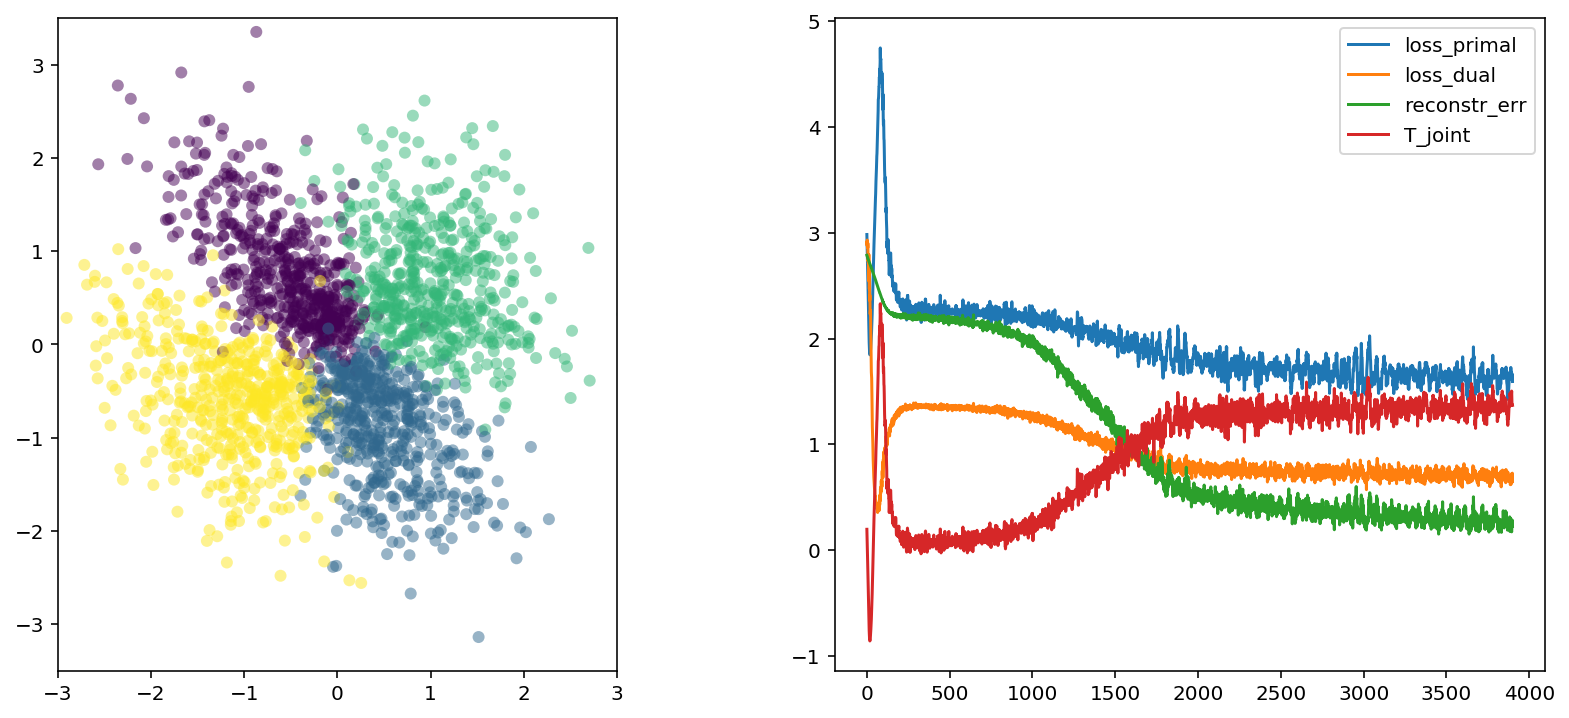

70.86/sec


In [6]:
def randn(shape, device):
    if device == 'cpu':
        return torch.randn(*shape).to(device)
    else:
        return torch.cuda.FloatTensor(*shape).normal_()  
    
try:
    start_time = time.time()
    for it in range(4000):
        eps = randn((args['batch_size'], args['eps_dim']), args['device'])
        z_sampled = randn((args['batch_size'], args['latent_dim']), args['device'])

        # opt primal
        z_inferred = Q(x_real, eps)
        x_reconstr = P(z_inferred)
        T_joint = T(x_real, z_inferred)

        reconstr_err = torch.sum(F.binary_cross_entropy_with_logits(x_reconstr, x_real, reduce=False), -1)
        loss_primal = torch.mean(reconstr_err + T_joint)
        loss_primal.backward(retain_graph=True)
        opt_primal.step()
        zero_grad()

        # opt dual
        T_separate = T(x_real, z_sampled)
        
        loss_dual = -torch.mean(
            F.logsigmoid(T_joint) +
            F.logsigmoid(-T_separate))

        loss_dual.backward()
        opt_dual.step()
        zero_grad()

        if it % 100 == 0:
            results = []
            n_viz = 4
            for i in range(n_viz):
                eps = randn((args['batch_size'], args['eps_dim']), args['device'])
                z_sample = Q(x_real, eps)
                results.append(z_sample.data.cpu().numpy())
            z = np.vstack(results)

            plt.figure(figsize=(14,6), facecolor='white')
            plt.title('pytorch')
            plt.subplot(121, aspect='equal')
            plt.scatter(z[:,0], z[:,1], c=np.tile(labels, n_viz), edgecolor='none', alpha=0.5)
            plt.xlim(-3, 3)
            plt.ylim(-3.5, 3.5)

            plt.subplot(122)
            for key in losses:
                plt.plot(losses[key], label=key)
            plt.legend(loc='upper right')
            
            clear_output(wait=True)
            plt.show()
            speed = (it + 1) / (time.time() - start_time)
            print(f'{speed:.2f}/sec')

        losses['loss_primal'].append(loss_primal.item())
        losses['loss_dual'].append(loss_dual.item())
        losses['reconstr_err'].append(torch.mean(reconstr_err).item())
        losses['T_joint'].append(torch.mean(T_joint).item())
        
except KeyboardInterrupt:
    pass